In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model
from tda.sim.sensors.oracle import Oracle

from tda.tracker.filters.linear_kalman import LinearKalman

In [5]:
def F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F

def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

H = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

R = 3 * np.eye(3)
#R[0, 0] = R[1, 1] = R[2, 2] = 3

x_hat_0 = np.zeros(6)
P_hat_0 = 1e9 * np.eye(6)

kf = LinearKalman(x_hat_0, P_hat_0, F, H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        kf.update(m.localize_measurement())

kf_record = kf.record()

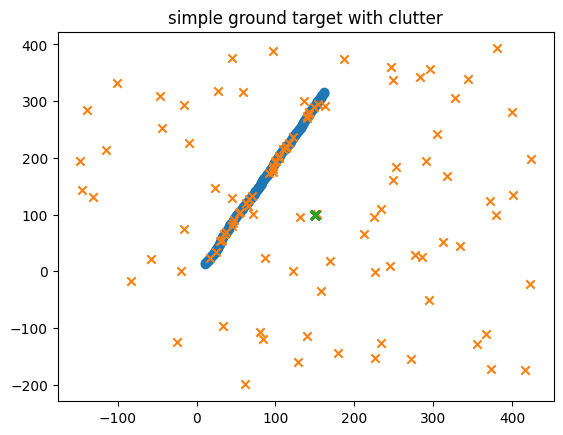

In [2]:
sim = Simulation(sim_length=150)

extent = np.array([[-300, -300, 0],
                   [300, 300, 10]]).T

platform = LTIObject(1, np.array([150, 100, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, np.eye(3) * 2.25, prob_detect=1.0, field_of_regard=extent)
oracle.add_clutter_model(clutter_model.PoissonClutter(oracle, 1))
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.11
target_Q[1, 1] = 0.07

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

sim_records = sim.run()

plt.title("simple ground target with clutter")
plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"])
plt.scatter(sim_records["oracle1"]["target_x"] + sim_records["oracle1"]["sensor_x"], sim_records["oracle1"]["target_y"] + sim_records["oracle1"]["sensor_y"], marker="x")
plt.scatter(sim_records["oracle1"]["sensor_x"], sim_records["oracle1"]["sensor_y"], marker="x")